<a href="https://colab.research.google.com/github/ricfrr/deepLearning/blob/master/market_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from numpy import array
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


In [24]:

from google.colab import drive
drive.mount('/content/gdrive')
!mkdir dataset
!cp "gdrive/My Drive/dataset/nasdaq100_padding.csv" dataset/


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
mkdir: cannot create directory ‘dataset’: File exists


In [25]:
from tensorboardcolab import TensorBoardColab

# Instantiate visualizer
tb = TensorBoardColab(graph_path='./log')

Wait for 8 seconds...
TensorBoard link:
http://2f10d06d.ngrok.io


In [0]:
class Loader():

    def __init__(self, path):
        self.path = path
        self.x = []
        self.y = []
        self.y_test = []
        self.x_test = []
        self.x_train = []
        self.y_train = []
        self.test_size = 0
        self.numpoints = 0
        self.device = torch.device(
            'cuda:0' if torch.cuda.is_available() else 'cpu')
        #self.to(self.device)


    def loadData(self):
        print("start Loading data")
        data = pandas.read_csv(self.path)
        i = 0
        for index, row in data.iterrows():
            self.x.append(i)
            self.y.append(row['GOOGL'])
            i = i+1
        self.numpoints = i
        self.test_size = int(self.numpoints*0.8)
        sc = MinMaxScaler(feature_range = (0, 1))
        self.y = np.array(self.y)
        self.y = sc.fit_transform(self.y.reshape(-1, 1))
        #self.x = np.array(self.x)
        #self.x = self.x.reshape(-1,1)
        for k in range(40, self.numpoints-self.test_size):
          self.x_train.append(self.y[k-40:k])
          self.y_train.append(self.y[k+1])
        
        for i in range (self.numpoints-self.test_size,self.numpoints-self.test_size+7):
          self.x_test.append(self.y[i-40:i]) 
          self.y_test.append(self.y[i+1])
        
        self.reshape()
        print("finished Loading data")

    def reshape(self):
        self.x_train = np.array(self.x_train)
        self.x_test = np.array(self.x_test)
        self.y_test = np.array(self.y_test)
        self.y_train = np.array(self.y_train)
        
        self.toTensor()

    def toTensor(self):
        self.x_train = torch.from_numpy(self.x_train).type(torch.Tensor).view(len(self.x_train),-1,1)
        self.x_test = torch.from_numpy(self.x_test).type(torch.Tensor)
        self.y_train = torch.from_numpy(self.y_train).type(torch.Tensor)
        self.y_test = torch.from_numpy(self.y_test).type(torch.Tensor)
        
        self.x_train = torch.Tensor(self.x_train).to(self.device)
        self.y_train = torch.Tensor(self.y_train).to(self.device)
        
        self.x_test = torch.Tensor(self.x_test).to(self.device)
        self.y_test = torch.Tensor(self.y_test).to(self.device)

    def plotData(self):
        plt.plot(self.x,self.y)
        plt.title('google nasdaq data')
        plt.xlabel('days')
        plt.ylabel('value')
        plt.show()

In [0]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.x_train =[]
    self.lstm1 = nn.LSTM(input_size=1, hidden_size=48, num_layers=3, dropout=0.2,batch_first=True)
    self.lstm2 = nn.LSTM(input_size=48, hidden_size=64, num_layers=5, dropout=0.2,batch_first=True)
    self.fc = nn.Linear(64, 1)
    self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')   
    self.h0 = []
    self.c0 = []
    self.h1 = []
    self.c1 = []
    self.to(self.device)

  def forward(self,x):
    x.to(self.device)
    batches = x.size(0)
    #self.initialize_hidden(x) 
    (x, _) = self.lstm1(x,(self.h0, self.c0))  
    (x, _) = self.lstm2(x,(self.h1, self.c1))   
    x = x[:,-1,:]  # Keep only the output of the last iteration.
    x =self.fc(x)
    return x
  def loadData(self,x):
    self.x_train = x 
    self.x_train.to(self.device)
    
  def initialize_hidden(self,x):
    x.to(self.device)
    batches = x.size(0)
    self.h0 = torch.randn([3, batches, 48]).to(self.device)
    self.c0 = torch.randn([3, batches, 48]).to(self.device)
    
    self.h1 = torch.randn([5, batches, 64]).to(self.device)
    self.c1 = torch.randn([5, batches, 64]).to(self.device)
  
  def forecast(self,x):
    x.to(self.device)
    batches = x.size(0)

    #self.h0 = torch.randn([3, batches, 48]).to(self.device)
    #self.c0 = torch.randn([3, batches, 48]).to(self.device)
    (x, _) = self.lstm1(x) 
    (x, _) = self.lstm2(x) 
    
    x = x[:,-1,:]  # Keep only the output of the last iteration.
    x =self.fc(x)
    return x


start Loading data
finished Loading data
Epoch 1/10000, loss = 3381.04443359375,  accuracy =0.3728484511375427
Epoch 2/10000, loss = 3108.94775390625,  accuracy =0.3414660096168518
Epoch 3/10000, loss = 2844.73095703125,  accuracy =0.30602264404296875
Epoch 4/10000, loss = 2578.85009765625,  accuracy =0.2735500633716583
Epoch 5/10000, loss = 2306.2802734375,  accuracy =0.23643238842487335
Epoch 6/10000, loss = 2021.88232421875,  accuracy =0.19978486001491547
Epoch 7/10000, loss = 1718.27197265625,  accuracy =0.15621934831142426
Epoch 8/10000, loss = 1388.658447265625,  accuracy =0.11221878975629807
Epoch 9/10000, loss = 1029.7789306640625,  accuracy =0.06185110658407211
Epoch 10/10000, loss = 653.16943359375,  accuracy =0.017936188727617264
Epoch 11/10000, loss = 321.9942321777344,  accuracy =0.002218633657321334
Epoch 12/10000, loss = 239.46861267089844,  accuracy =0.03803345933556557
Epoch 13/10000, loss = 593.16943359375,  accuracy =0.04316962882876396
Epoch 14/10000, loss = 627.052

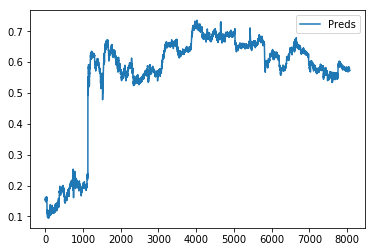

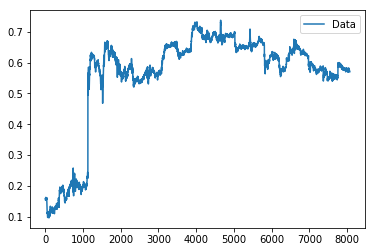

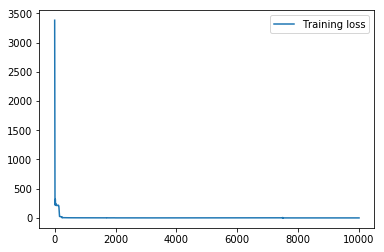

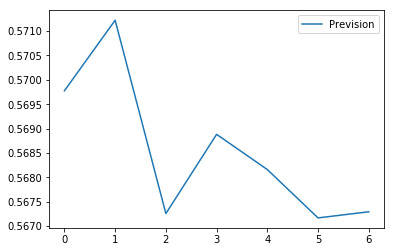

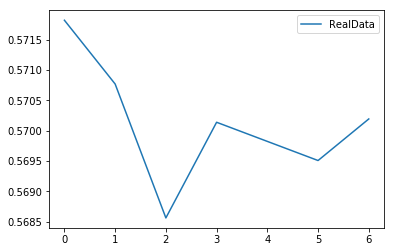

In [28]:
loader = Loader('/content/dataset/nasdaq100_padding.csv')
loader.loadData()


visualization_name ="marker_forecasting" #for plotting tensorboard
model = Model()
#model.loadData(loader.x_train)
model.initialize_hidden(loader.x_train)

criterion = nn.MSELoss(reduction='sum')
prevision = nn.MSELoss(reduction='mean')

optimizer = torch.optim.Adam(model.parameters(),weight_decay=0.000001, lr = 0.001)

n_epochs = 10000
trainig_loss = np.zeros(n_epochs)

for epoch in range(n_epochs):
  model.train()
  optimizer.zero_grad()
  y_ = model.forward(loader.x_train)  
  loss = criterion(y_, loader.y_train)
  loss.backward()
  optimizer.step()
  trainig_loss[epoch] = loss.item()
  
  
  market_forecast = model.forecast(loader.x_test)
  validation = prevision(market_forecast,loader.y_test)
  

  print(f"Epoch {epoch+1}/{n_epochs}, loss = {loss.item()},  accuracy ={validation.item()}")
  tb.save_value('Loss/train_loss', visualization_name, epoch + 1, loss.item())
  tb.save_value('Accuracy', visualization_name, epoch + 1, validation.item())
  # Update plots 
  tb.flush_line(visualization_name)
  


y_ = torch.Tensor.cpu(y_)
y_train = torch.Tensor.cpu(loader.y_train)
plt.plot(y_.detach().numpy(), label="Preds")
plt.legend()
plt.show()

plt.plot(y_train.detach().numpy(), label="Data")
plt.legend()
plt.show()

plt.plot(trainig_loss, label="Training loss")
plt.legend()
plt.show()


market_forecast = model.forecast(loader.x_test)
forec = torch.Tensor.cpu(market_forecast)
y_test  = torch.Tensor.cpu(loader.y_test)

plt.plot(forec.detach().numpy(), label="Prevision")
plt.legend()
plt.show()


plt.plot(y_test.detach().numpy(), label="RealData")
plt.legend()
plt.show()





